<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Addestramento_modello_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

## Import librerie

In [4]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import shutil
import copy


##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
False


RuntimeError: ignored

##Def variabili

In [5]:
#scanner
scanner_name = 'DigitalPersona'

#salvataggio modello
model_save_name = 'model_DenseNet201'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/{model_save_name}" 

#dataset
pathDataset=F'/content/gdrive/MyDrive/Dataset_impronte/training/{scanner_name}'
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

##Parametri

In [6]:
batch_size = 128

##Collegamento google drive

In [7]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Dataset**

##Caricamento dataset e creazione Dataloader

In [8]:
import torch
import torchvision
from torchvision import transforms

data_transform=transforms.Compose([transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


train_dataset = datasets.ImageFolder(pathDataset,transform=data_transform)

#train_dataset = torchvision.datasets.STL10('/stl10',split='train',transform=data_transform,download=True)


In [9]:
print(len(train_dataset))

2000


##Nomi classi

In [10]:
classes_name=train_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)

['Live', 'Spoof']
2


# **Creazione modello**

##Load model pre-trained

In [11]:
model_conv = models.vgg19(pretrained=True,progress=True)
for param in model_conv.parameters():
  param.requires_grad = False #non modifico i parametri della parte riguardante le features durante il training, poiché voglio usare quella parte così com'è stata pre-addestrata

print(model_conv)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##Aggiunta classificatore e freeze parametri

In [12]:
model_conv.classifier[6]=nn.Linear(4096,class_number)

for param in model_conv.classifier.parameters():
  param.requires_grad = True #invece pongo il calcolo del gradiente del classificatore, ovvero attivo il calcolo dei pesi

print(model_conv) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

#**Training**

##Def train definitiva

In [13]:
from collections import OrderedDict
from functools import partial
import sys

import numpy as np
import sys
import torch

from functools import partial
from torch.utils.data import DataLoader, TensorDataset


##### Data utils #####

def log_to_message(log):
    fmt = "{0}: {1}"
    return "    ".join(fmt.format(k, v) for k, v in log.items())


class ProgressBar(object):
    """Cheers @ajratner"""

    def __init__(self, n, length=40):
        # Protect against division by zero
        self.n      = max(1, n)
        self.nf     = float(n)
        self.length = length
        # Precalculate the i values that should trigger a write operation
        #self.ticks = set([round(i/100.0 * n) for i in range(101)])
        #self.ticks.add(n-1)
        self.ticks=range(n)
        self.bar(0)

    def bar(self, i, message=""):
        """Assumes i ranges through [0, n-1]"""
        if i in self.ticks:
            b = int(np.ceil(((i+1) / self.nf) * self.length))
            sys.stdout.write("\r[{0}{1}] {2}%\t{3}".format(
                "="*b, " "*(self.length-b), int(100*((i+1) / self.nf)), message
            ))
            sys.stdout.flush()

    def close(self, message=""):
        # Move the bar to 100% before closing
        self.bar(self.n-1)
        sys.stdout.write("{0}\n\n".format(message))
        sys.stdout.flush()



def training_f(train_dataset, numEpochs, model_conv, criterionCNN, optimizer_conv,batch_size, validation_split=0):
  
  best_acc = 0
  best_loss=0
  best_epoca = 0
  
  best_model_wts = copy.deepcopy(model_conv.state_dict())

  if validation_split:
      train_size = int(len(train_dataset) * 0.8)
      val_size = len(train_dataset) - train_size
      train_dataset, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])
      traingen = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, shuffle=True,num_workers=2)
      valgen = torch.utils.data.DataLoader(val_set, pin_memory=True, batch_size=batch_size)
  
  else: traingen = torch.utils.data.DataLoader(train_dataset, pin_memory=True, batch_size=batch_size, shuffle=True,num_workers=2)
      
  for epochs in range(1,numEpochs + 1):
    since = time.time()
    
    print("Epoch {0} / {1}".format(epochs, numEpochs))
    log = OrderedDict()
    modelLoss_train = 0.0
    modelAcc_train = 0.0
    
    model_conv.train() 
    
    totalSize = 0
    batch_i=0
    num_batch=int(np.ceil(len(train_dataset)/batch_size))
    pb = ProgressBar(num_batch)
    #for each batch: operazioni per gli algoritmi di ottimizzazione
    for inputs,labels in traingen:
      #inputs = inputs.type(torch.FloatTensor).cuda()
      #labels = labels.cuda()
      
      batch_i=batch_i+1
      
      optimizer_conv.zero_grad()
      model_conv.zero_grad()
      
      y = model_conv(inputs)
      outp, preds = torch.max(y, 1)   
        
      lossCNN = criterionCNN(y, labels) #media per batch

      modelLoss_train += lossCNN.item() * inputs.size(0)
      totalSize += inputs.size(0)
      modelAcc_train += torch.sum(preds == labels.data).item()

      log['batch']="{0} / {1}".format(batch_i, num_batch)
      log['loss'] =round(modelLoss_train/totalSize,2)
      log['acc']=round(modelAcc_train/totalSize,2)
      log['Validation']=False
      pb.bar(batch_i, log_to_message(log))

      lossCNN.backward()  # pred = f(x)   -> loss = L(f(x), l_true)
      
      optimizer_conv.step()
    
    #calcolo loss e accuracy
    modelLoss_epoch_train = modelLoss_train/totalSize
    modelAcc_epoch_train  = modelAcc_train/totalSize
    
    log['loss']=modelLoss_epoch_train
    log['acc']=modelAcc_epoch_train
    pb.close(log_to_message(log))

    if validation_split:    
        #validation
               
        model_conv.eval()
        totalSize_val = 0
        modelLoss_val = 0.0
        modelAcc_val = 0.0

        log['Validation']=True
        log['loss_val']=modelLoss_val
        log['acc_val']=modelAcc_val
        pb.close(log_to_message(log))

        for inputs,labels in valgen:
          #inputs = inputs.type(torch.FloatTensor).cuda()
          #labels = labels.cuda()
          
          y = model_conv(inputs)
          outp, preds = torch.max(y, 1)
          lossCNN = criterionCNN(y, labels)

          modelLoss_val += lossCNN.item() * inputs.size(0)
          totalSize_val += inputs.size(0)
          modelAcc_val += torch.sum(preds == labels.data).item()        

          log['loss_val'] =round(modelLoss_epoch_val/totalSize_val,2)
          log['acc_val']=round(modelAcc_epoch_val/totalSize_val,2)
          pb.close(log_to_message(log))

        modelLoss_epoch_val=modelLoss_val/totalSize_val
        modelAcc_epoch_val = modelAcc_val/totalSize_val
        time_elapsed = time.time()-since

        log['loss_val'] =round(modelLoss_epoch_val,2)
        log['acc_val']=round(modelAcc_epoch_val,2)
        log['time']=round(time_elapsed,2)
        
        if (modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss) :
          best_acc = modelAcc_epoch_val
          best_loss = modelLoss_epoch_val
          best_epoca = epochs
          best_model_wts = copy.deepcopy(model_conv.state_dict())
          
    else: 
      best_model_wts = copy.deepcopy(model_conv.state_dict())
      
  #pb.close(log_to_message(log))

  model_conv.load_state_dict(best_model_wts)
  return model_conv




##Set iperparametri

In [14]:
#iper-parametri iniziali
learning_rate = 1e-3
momentum=0.9
num_epoch = 2

#richiamo funzione che effettua il training con validation

#model_conv = model_conv.cuda() #sposta i calcoli sulla gpu
criterion = nn.CrossEntropyLoss() #criterio dell'aggiornamento del gradiente: minimizzazione funzione loss entropia
optimizer_conv = optim.SGD(model_conv.classifier.parameters(),lr=learning_rate,momentum=momentum)

##Addestramento

In [ ]:
best_model=training_f(train_dataset, num_epoch, model_conv, criterion, optimizer_conv,batch_size=5, validation_split=0.2)

#**Testing**

##Testing1 con loader

###Load test set

In [16]:
test_set = datasets.ImageFolder(pathTestset,transform=data_transform)
testgen = torch.utils.data.DataLoader(test_set, pin_memory=True, batch_size=batch_size,num_workers=2)

###Test

In [ ]:
Acc=0
best_model=model_conv #per ora non ho ancora fatto l'addestramento completo
best_model.eval()
num_batch=int(np.ceil(len(test_set)/batch_size))
batch_i=0
for inputs,labels in testgen:
  #inputs = input.type(torch.FloatTensor).cuda()
  #labels = label.cuda()
  batch_i=batch_i+1      
  print("Batch: {0} / {1}".format(batch_i, num_batch))  
  y = best_model(inputs)
  outp, preds = torch.max(y, 1)
  Acc += torch.sum(preds == labels.data).item()

Acc = Acc/len(test_set)

##Testing2 con dataframe

###creazione dataframe con predizioni e classi reali

In [ ]:
from PIL import Image
import pandas as pd

model_conv.eval()
Test = pd.DataFrame()
i=0
Directory = os.listdir(pathTestset)
for classe in Directory:
  classes_path = os.listdir(pathTestset + "/"+classe)  
  print(classe)
  for input in classes_path:
    i=i+1
    #print("Working on {0} / {1}".format(i,len(test_set)))
    if input.endswith('.png'):  
      img = Image.open(pathTestset+"/"+classe+'/' + input)
      img = data_transform(img)
      img = img.unsqueeze_(0)
      outputs = model_conv(img)
      _, predicted = torch.max(outputs, 1)
      Test = Test.append({'img': input.split('.')[0],
                          'predicted': classes_name[predicted.item()],
                          'real': classe} ,ignore_index = True)

In [64]:
img.numpy().shape

(1, 3, 288, 224)

###Stampa accuracy

In [52]:
true_label = Test.real.values
predicted = Test.predicted.values

print(round((np.sum((true_label == predicted).astype(int)))/Test.shape[0],4)*100)

84.21


In [51]:
Test[:5]

,img,predicted,real
0,DigitalPersona_Live_004_0_0,Spoof,Live
1,DigitalPersona_Live_004_1_0,Live,Live
2,DigitalPersona_Live_004_2_0,Live,Live
3,DigitalPersona_Live_004_3_0,Live,Live
4,DigitalPersona_Live_004_4_0,Live,Live


#**Attacco**

In [ ]:
#importa ART
!pip install adversarial-robustness-toolbox

In [60]:
from art.estimators.classification import PyTorchClassifier
#creazione classificatore di tipo Keras usando il modello addestrato, poiché ART supporta solo determinati classificatori
classifier = PyTorchClassifier(model=model_conv,loss=criterion,input_shape=(224,224,3),nb_classes=2)

In [65]:
from art.attacks.evasion import FastGradientMethod
# FGM
attack = FastGradientMethod(estimator=classifier, eps=0.1)

In [109]:
input,label=next(iter(testgen))
x_test=input.numpy()
y_test=label.numpy()

In [104]:
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[2], x_test.shape[3], x_test.shape[1])
#x_test = x_test.transpose((0, 2, 3, 1))
print(x_test.shape)

(128, 3, 288, 224)
(128, 288, 224, 3)


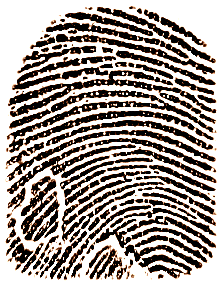

In [105]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(x_test[1]*255)

In [110]:
from art.utils import to_categorical
y_test=to_categorical(y_test,2)
print(y_test[:5])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [111]:
x_test.shape

(128, 3, 288, 224)

In [114]:
x_test_adv = attack.generate(x=x_test[:10],y=y_test[:10])

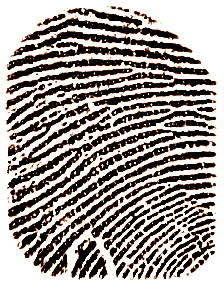

In [123]:
cv2_imshow(x_test[0].transpose((1, 2, 0))*255)

#**Salvataggio modello**

In [ ]:
#salva modello su drive
model.save(path_model_save)